In [1]:
import pandas as pd
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tools import add_constant
from statsmodels.regression.linear_model import RegressionResults
import seaborn as sns
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
sns.set(style="ticks")
%matplotlib inline

In [2]:
nyc_cab_df = pd.read_csv('nyc_car_hire_data.csv', low_memory=False)

In [3]:
def train_test_split(df, n_samples, validation=False):
    if validation:
        nyc_cab_sample = df.sample(n=n_samples)

        nyc_cab_sample['lpep_pickup_datetime'] = nyc_cab_sample['lpep_pickup_datetime'].apply(lambda dt: pd.to_datetime(dt).hour)
        nyc_cab_sample['Lpep_dropoff_datetime'] = nyc_cab_sample['Lpep_dropoff_datetime'].apply(lambda dt: pd.to_datetime(dt).hour)

        msk = np.random.rand(len(nyc_cab_sample)) < 0.8
        non_test = nyc_cab_sample[msk]
        test = nyc_cab_sample[~msk]
        
        msk = np.random.rand(len(non_test)) < 0.7
        train = non_test[msk]
        validation = non_test[~msk]
        
        return train, validation, test
    
    else:
        nyc_cab_sample = df.sample(n=n_samples)

        nyc_cab_sample['lpep_pickup_datetime'] = nyc_cab_sample['lpep_pickup_datetime'].apply(lambda dt: pd.to_datetime(dt).hour)
        nyc_cab_sample['Lpep_dropoff_datetime'] = nyc_cab_sample['Lpep_dropoff_datetime'].apply(lambda dt: pd.to_datetime(dt).hour)

        msk = np.random.rand(len(nyc_cab_sample)) < 0.8
        train = nyc_cab_sample[msk]
        test = nyc_cab_sample[~msk]

        return train, test

---

## Dimensionality Reduction: PCA

In [45]:
train, validation, test = train_test_split(nyc_cab_df, 1000, validation=True)

y_train = train['Fare_amount'].values
y_val = validation['Fare_amount'].values
y_test = test['Fare_amount'].values

regression_model = LinearRegression(fit_intercept=True)

all_predictors = ['Trip Length (min)', 'Type', 'Trip_distance', 'TMAX', 'TMIN', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime', 'Pickup_longitude', 'Pickup_latitude', 'SNOW', 'SNWD', 'PRCP']

### 1. Variable Selection: Backwards

In [46]:
def get_aic(X_train, y_train):
    X_train = add_constant(X_train)
    model = sm.OLS(y_train, X_train).fit()
    return model.aic

X_train = train[all_predictors].values
predictors = [(all_predictors, get_aic(X_train, y_train))]

for k in range(len(all_predictors), 1, -1):
    best_k_predictors = predictors[-1][0]
    aics = []
    
    for predictor in best_k_predictors:
        k_minus_1 = list(set(best_k_predictors) - set([predictor]))
        X_train = train[k_minus_1].values

        aics.append(get_aic(X_train, y_train))
    
    best_k_minus_1 = list(set(best_k_predictors) - set([best_k_predictors[np.argmin(aics)]]))
    predictors.append((best_k_minus_1, np.min(aics)))
    
best_predictor_set = sorted(predictors, key=lambda t: t[1])[-1]

In [47]:
best_predictor_set = sorted(predictors, key=lambda t: t[1])[0]

X_train = train[best_predictor_set[0]].values
X_val = validation[best_predictor_set[0]].values  
X_test = test[best_predictor_set[0]].values  
regression_model.fit(np.vstack((X_train, X_val)), np.hstack((y_train, y_val)))

print 'best predictor set: {}\ntest R^2: {}'.format(best_predictor_set[0], regression_model.score(X_test, y_test))

best predictor set: ['Trip_distance', 'Pickup_latitude', 'SNOW', 'SNWD', 'Trip Length (min)', 'Type']
test R^2: 0.872835547667


## 2. Variable Selection: LASSO Regression

In [48]:
X_train = train[all_predictors].values
X_val = validation[all_predictors].values
X_non_test = np.vstack((X_train, X_val))
X_test = test[all_predictors].values

y_non_test = np.hstack((y_train, y_val))

lasso_regression = Lasso(alpha=1.0, fit_intercept=True)
lasso_regression.fit(X_non_test, y_non_test)

print 'Lasso regression model:\n {} + {}^T . x'.format(lasso_regression.intercept_, lasso_regression.coef_)

Lasso regression model:
 4.60928614757 + [ 0.33553449  3.99560125  1.90450068 -0.00711279 -0.         -0.         -0.
 -0.          0.          0.          0.          0.        ]^T . x


In [49]:
print 'Test R^2: {}'.format(lasso_regression.score(X_test, y_test))

Test R^2: 0.769256448531


### 3. Principal Component Regression

In [50]:
pca = PCA(n_components=4)
pca.fit(X_non_test)
X_non_test_pca = pca.transform(X_non_test)
X_test_pca = pca.transform(X_test)

print 'Explained variance ratio:', pca.explained_variance_ratio_

Explained variance ratio: [ 0.36208855  0.28808448  0.24725944  0.05093714]


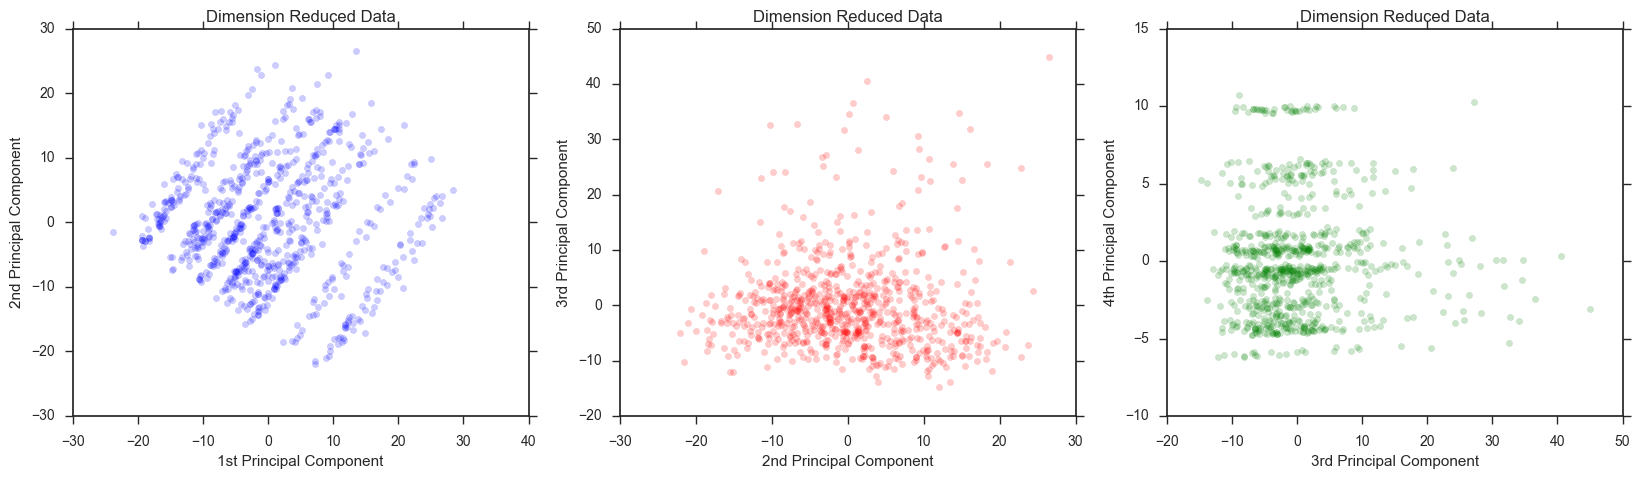

In [51]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].scatter(X_non_test_pca[:, 0], X_non_test_pca[:, 1], color='blue', alpha=0.2, label='train R^2')

ax[0].set_title('Dimension Reduced Data')
ax[0].set_xlabel('1st Principal Component')
ax[0].set_ylabel('2nd Principal Component')

ax[1].scatter(X_non_test_pca[:, 1], X_non_test_pca[:, 2], color='red', alpha=0.2, label='train R^2')

ax[1].set_title('Dimension Reduced Data')
ax[1].set_xlabel('2nd Principal Component')
ax[1].set_ylabel('3rd Principal Component')

ax[2].scatter(X_non_test_pca[:, 2], X_non_test_pca[:, 3], color='green', alpha=0.2, label='train R^2')

ax[2].set_title('Dimension Reduced Data')
ax[2].set_xlabel('3rd Principal Component')
ax[2].set_ylabel('4th Principal Component')

plt.show()

In [52]:
print 'first pca component:', pca.components_[0]
print '\nsecond pca component:', pca.components_[1]
print '\nthird pca component:', pca.components_[2]
print '\nfourth pca component:', pca.components_[3]

first pca component: [ 0.16637199 -0.0061908   0.05964085  0.68960015  0.43518447 -0.39321397
 -0.38482642 -0.02192225  0.01246143  0.          0.         -0.02113384]

second pca component: [  1.23346116e-01   9.14355182e-05   4.28735422e-02  -4.95472359e-01
  -2.89327111e-01  -5.67704322e-01  -5.75582678e-01  -1.55658011e-03
   1.04577034e-03  -0.00000000e+00  -0.00000000e+00   1.25466167e-02]

third pca component: [ 0.94336289 -0.00541284  0.24730168 -0.06941386 -0.02321144  0.13865907
  0.15515707 -0.01228155  0.00609353 -0.         -0.         -0.00582758]

fourth pca component: [ 0.02038416  0.00363109  0.00367575  0.52143474 -0.84844533 -0.01361482
 -0.00528908  0.07050404 -0.03892646  0.         -0.         -0.03323683]


In [53]:
regression_model = LinearRegression(fit_intercept=True)
regression_model.fit(X_non_test_pca, y_non_test)

print 'Test R^2: {}'.format(regression_model.score(X_test_pca, y_test))

Test R^2: 0.441107611991


### 3. Principal Component Regression With Polynomial and Interaction Terms

In [54]:
gen_poly_terms = PolynomialFeatures(degree=6, interaction_only=False)

min_max_scaler = MinMaxScaler()
X_non_test = min_max_scaler.fit_transform(X_non_test)
X_test = min_max_scaler.fit_transform(X_test)

X_train_full_poly = gen_poly_terms.fit_transform(X_non_test)
X_test_full_poly = gen_poly_terms.fit_transform(X_test)

print 'number of total predictors', X_train_full_poly.shape[1]

number of total predictors 18564


In [55]:
pca = PCA(n_components=15)
pca.fit(X_train_full_poly)
X_train_pca = pca.transform(X_train_full_poly)
X_test_pca = pca.transform(X_test_full_poly)

print 'Explained variance ratio:', pca.explained_variance_ratio_

Explained variance ratio: [ 0.35693778  0.23422959  0.1540763   0.07589905  0.03364385  0.02319863
  0.02181426  0.01871246  0.01443526  0.01277375  0.00859637  0.0061197
  0.00502354  0.00429344  0.00315522]


In [56]:
regression_model = LinearRegression(fit_intercept=True)
regression_model.fit(X_train_pca, y_non_test)

print 'Test R^2: {}'.format(regression_model.score(X_test_pca, y_test))

Test R^2: 0.592982028762


In [57]:
pca = PCA(n_components=45)
pca.fit(X_train_full_poly)
X_train_pca = pca.transform(X_train_full_poly)
X_test_pca = pca.transform(X_test_full_poly)

print 'Explained variance ratio:', pca.explained_variance_ratio_

Explained variance ratio: [  3.56937784e-01   2.34229594e-01   1.54076300e-01   7.58990528e-02
   3.36438546e-02   2.31986300e-02   2.18142606e-02   1.87124592e-02
   1.44352591e-02   1.27737462e-02   8.59637205e-03   6.11969508e-03
   5.02354097e-03   4.29344481e-03   3.15521959e-03   2.86416745e-03
   2.49184605e-03   2.19477035e-03   1.88363810e-03   1.63182232e-03
   1.50780056e-03   1.43124576e-03   1.26785968e-03   1.17747808e-03
   1.07551109e-03   9.79624183e-04   9.17461089e-04   8.52337072e-04
   8.10656550e-04   6.04195835e-04   5.16704749e-04   4.27565951e-04
   3.49549044e-04   3.08195909e-04   2.73407051e-04   2.58563426e-04
   2.32049134e-04   2.16784086e-04   2.08299294e-04   1.90021116e-04
   1.81948633e-04   1.66883880e-04   1.36446159e-04   1.29544809e-04
   1.13363034e-04]


In [58]:
regression_model = LinearRegression(fit_intercept=True)
regression_model.fit(X_train_pca, y_non_test)

print 'Test R^2: {}'.format(regression_model.score(X_test_pca, y_test))

Test R^2: 0.460359766016


---

## Selecting the Components of PCA Using Cross Validation

In [59]:
regression_model = LinearRegression(fit_intercept=True)
kf = KFold(n_splits=5)

x_val_scores = []

for n in range(1, 80, 5):
    out = n * 1. / 80 * 100
    sys.stdout.write("\r%d%%" % out)
    sys.stdout.flush()
    
    pca = PCA(n_components=15)
    pca.fit(X_train_full_poly)
    
    validation_R_sqs = []
    for train_index, val_index in kf.split(X_train_pca):
        X_train, X_val = X_train_full_poly[train_index], X_train_full_poly[val_index]
        y_train, y_val = y_non_test[train_index], y_non_test[val_index]

        X_train_pca = pca.transform(X_train)
        X_val_pca = pca.transform(X_val)
        
        regression_model.fit(X_train_pca, y_train)
        validation_R_sqs.append(regression_model.score(X_val_pca, y_val))
        
    x_val_scores.append(np.mean(validation_R_sqs))
    
sys.stdout.write("\r%d%%" % 100)

100%

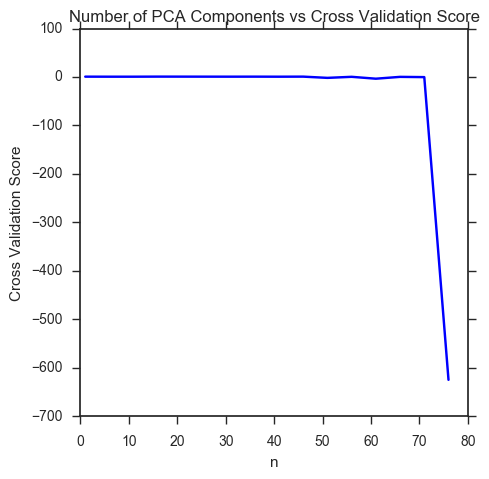

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(range(1, 80, 5), x_val_scores, color='blue')

ax.set_title('Number of PCA Components vs Cross Validation Score')
ax.set_xlabel('n')
ax.set_ylabel('Cross Validation Score')

plt.show()

In [61]:
best_n = range(1, 80, 5)[np.argmax(x_val_scores)]

pca = PCA(n_components=best_n)
pca.fit(X_train_full_poly)
X_train_pca = pca.transform(X_train_full_poly)
X_test_pca = pca.transform(X_test_full_poly)

regression_model.fit(X_train_pca, y_non_test)
test_R_sq = regression_model.score(X_test_pca, y_test)

print 'best regularization param is:', best_n
print 'the test R^2 for PC regression with n = {} is: {}'.format(best_n, test_R_sq)

best regularization param is: 16
the test R^2 for PC regression with n = 16 is: 0.353860535482
